In [116]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
import scanpy as sc
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csgraph
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import umap
from sklearn import linear_model
from matplotlib.lines import Line2D
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene

import gget
import sys

# locals
sys.path.append("../")
import utils as ut
import continuum as cont
reload(ut)
reload(cont)

<module 'continuum' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/continuum/continuum.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


# All Together!

In [3]:
""" Monocyte """
m1 = cont.getGroup(rna, labels, 'ND', 'Monocytes')
m2 = cont.getGroup(rna, labels, 'HFD8', 'Monocytes')
p1 = pd.concat([m1, m2])    

""" resident ATM """
m1 = cont.getGroup(rna, labels, 'ND', 'Mac1') # pole 1 is ATM

# p2 = pd.concat([m1, m2, m3], ignore_index=True)
p2 = pd.concat([m1], ignore_index=True)

""" LAM """
p3 = cont.getGroup(rna, labels, 'HFD14', 'Mac5')

print(f"{p1.shape=} {p2.shape=} {p3.shape=}")

p1.shape=(889, 31053) p2.shape=(136, 31053) p3.shape=(1870, 31053)


In [4]:
""" Get DEGs. Note: do we need to perform DE against all other cells, not just a single group? """
pairs  = [
    (p1, pd.concat([p2, p3])),
    (p2, pd.concat([p1, p3])),
    (p3, pd.concat([p1, p2])),
]

geneDupTresh = 3 # only genes counted < this will be considered
alpha = 0.01
p = 0.2 # percent of the population that must express each DEG
n = 50 # number of genes 

corrGenes = []

for px, py in pairs:
    # get the differnetially expressed genes
    deg = cont.getDEGs(px, py)
    genes, sig = cont.getSignificant(deg, alpha, n, p, method='log2foldchange')
    corrGenes += genes
    
    
""" remove genes that appear in multiple cell type DEGs """
print(f"{len(corrGenes)=} (all) {len(set(corrGenes))=} (unique)")
counts = Counter(corrGenes)
corrGenes = [k for k, v in counts.items() if v < geneDupTresh]
print(f"{len(corrGenes)=} (retained) ")
print('done')

alpha=0.01 ntests=31053 3.2365099111864026e-07
alpha=0.01 ntests=31053 3.2365099111864026e-07
alpha=0.01 ntests=31053 3.2365099111864026e-07
len(corrGenes)=150 (all) len(set(corrGenes))=106 (unique)
len(corrGenes)=101 (retained) 
done


In [5]:
macTypes = ['Mac1','Mac2','Mac3','Mac4','Mac5', 'Monocytes']

res = []

normalize = True
log = True
metric = 'correlation'

# build the signature of the poles
meanP1 = cont.getSignature(p1, corrGenes, norm=normalize, log=log)
meanP2 = cont.getSignature(p2, corrGenes, norm=normalize, log=log)
meanP3 = cont.getSignature(p3, corrGenes, norm=normalize, log=log)


for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    # get correlations to cell type
    rf = rf[corrGenes]
    rf = rf.fillna(0)
    
    if log:
        rf = np.log1p(rf)
    
    if normalize:
        rf[corrGenes] = sklearn.preprocessing.minmax_scale(rf[corrGenes], 
                                                           feature_range=(0, 1), axis=1)
        
    p1Dist = scipy.spatial.distance.cdist(rf, meanP1, metric)
    p2Dist = scipy.spatial.distance.cdist(rf, meanP2, metric)
    p3Dist = scipy.spatial.distance.cdist(rf, meanP3, metric)
    
    # normalize distance to range (0, 1)
    p1Dist = sklearn.preprocessing.minmax_scale(p1Dist, feature_range=(0, 1))
    p2Dist = sklearn.preprocessing.minmax_scale(p2Dist, feature_range=(0, 1))
    p3Dist = sklearn.preprocessing.minmax_scale(p3Dist, feature_range=(0, 1))
    
    pred = pd.DataFrame({
        'p1' : p1Dist.ravel(),
        'p2' : p2Dist.ravel(),
        'p3' : p3Dist.ravel(),
    })
    
    pred['cellId'] = rf.index
    pred['key'] = key
    
    pred = pd.merge(pred, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                   how='left', 
                   right_on='cellId',
                   left_on='cellId')
    
    res.append(pred)

res = pd.concat(res, ignore_index=True)
print(f"{res.shape=}")
res.head()

res.shape=(8329, 9)


p1        p2        p3              cellId key   cellType         x   
0  0.838296  0.196552  0.738880  AAAGAACGTCTACAGT.1  ND       Mac1  3.089298  \
1  0.819930  0.129552  0.584415  AAAGAACTCCTCGCAT.1  ND       Mac1  3.614130   
2  0.301373  0.800372  0.728490  AAAGGGCGTTAGGGTG.1  ND       Mac3  3.086352   
3  0.183743  0.825707  0.638148  AACAAAGAGTATAGGT.1  ND  Monocytes  3.178745   
4  0.292459  0.807702  0.674774  AACAAAGCACCGGCTA.1  ND       Mac3  4.344001   

          y    metaTypes  
0 -1.726030  Macrophages  
1 -1.571004  Macrophages  
2  6.166065  Macrophages  
3  4.929769    Monocytes  
4  5.801922  Macrophages

/tmp/ipykernel_2812489/1740204605.py:85: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


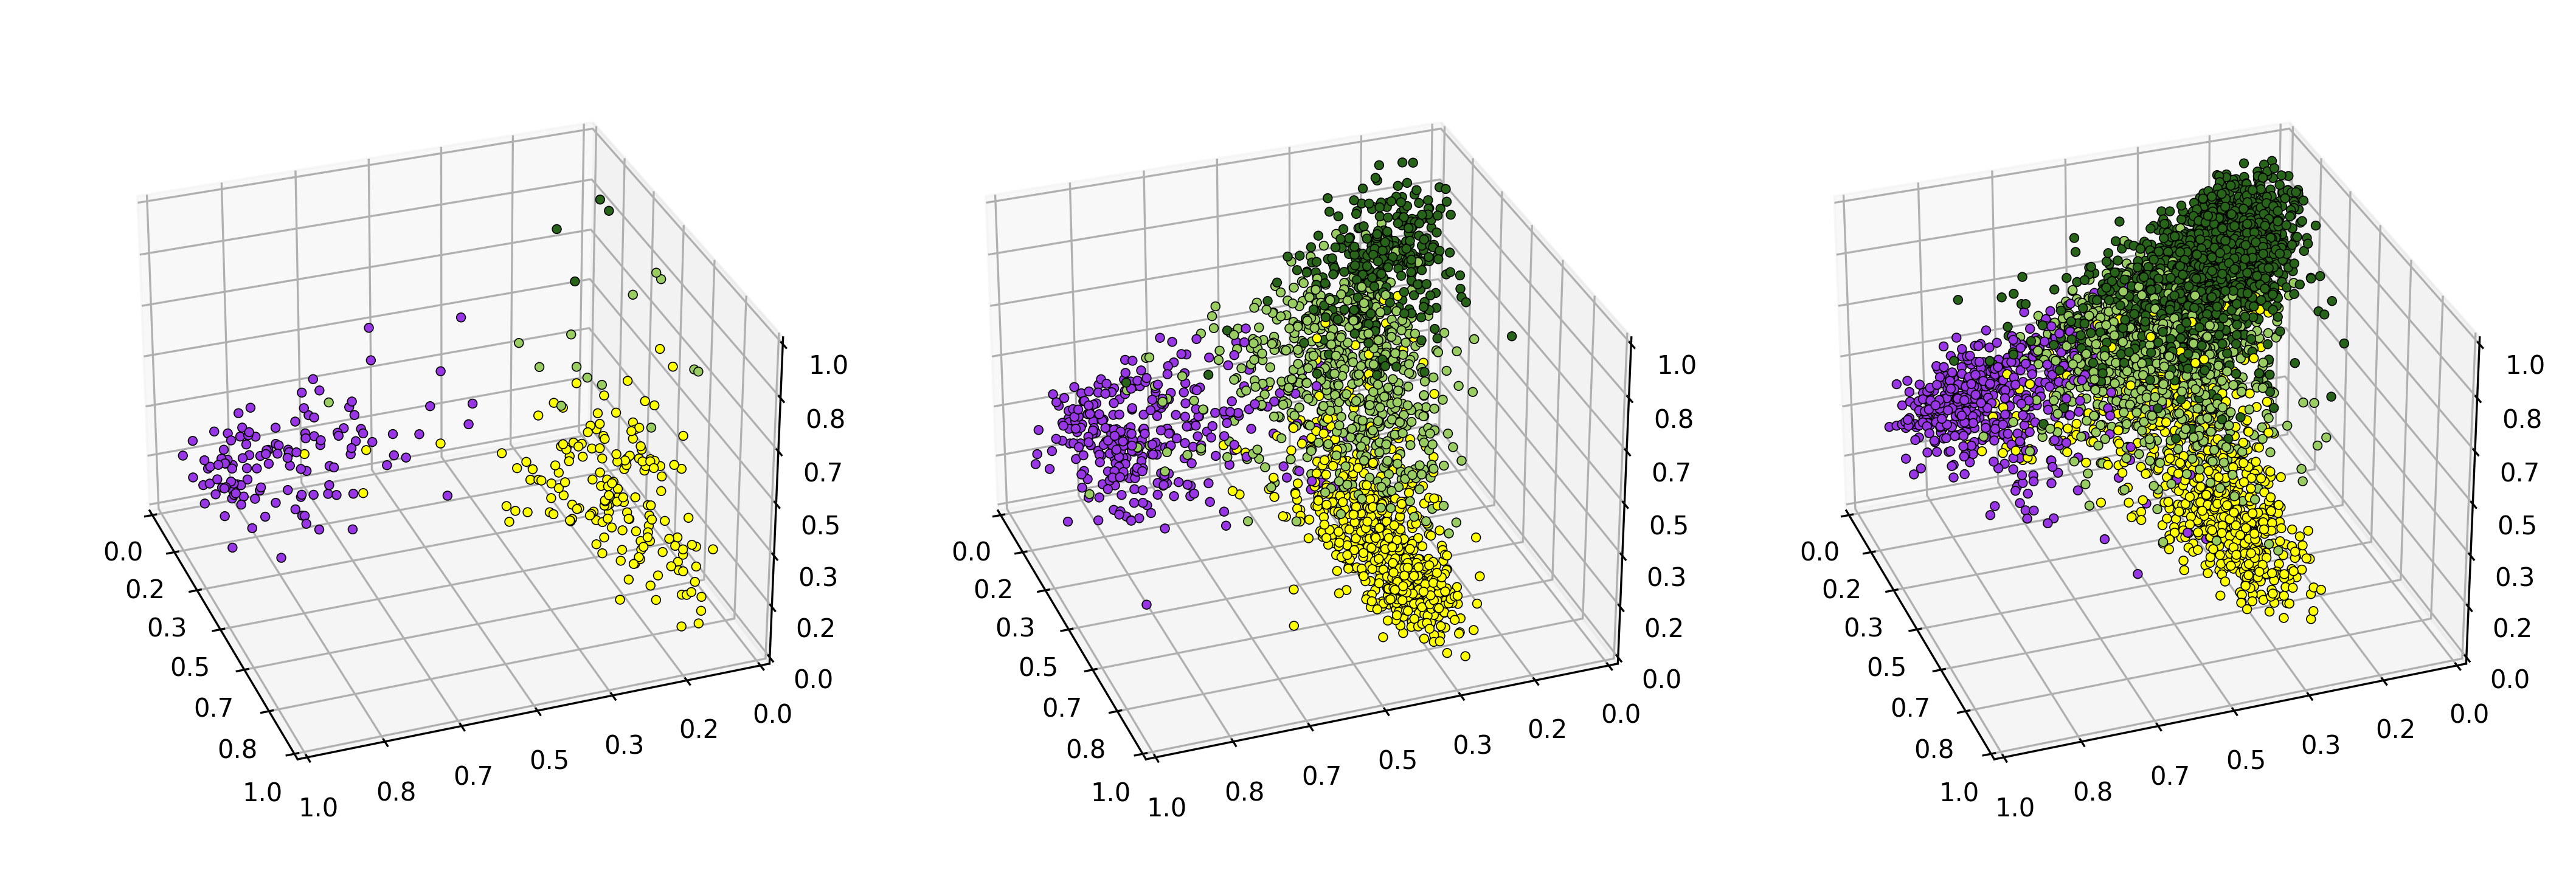

In [6]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf[pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5', "MN"])]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 18, 6
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()

for i, key in enumerate(keys):
    mask = (pdf['key'] == key)
    cx = pdf[mask]
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    ax.scatter(cx['p1'], 
               cx['p2'],
               cx['p3'], 
               c=cx['color'], 
               ec='k',
               # ec='None',
               s=50,
               alpha=1,
               zorder=5,
               lw=0.4,
               marker=".")

    # ax.set_title(keyMap[key])
    # ax.set_xlabel("Monocyte Similarity", labelpad=10)
    # ax.set_ylabel("Resident ATM Similarity", labelpad=10)
    # ax.set_zlabel("LAM Similarity", labelpad=10)
    
    ticks = np.linspace(0, 1, 7)
    tickLabels = [f"{x:.1f}" for x in ticks]
    
    ax.set_xticks(ticks, tickLabels)
    ax.set_yticks(ticks, tickLabels)
    ax.set_zticks(ticks, tickLabels)

    
    ax.set_xlim([0, 1])
    ax.set_ylim([1, 0])
    ax.set_zlim([0, 1])
    
    ax.view_init(azim=-20)
    ax.dist = 11

    # ax.view_init(elev=15, azim=75)
    
# plt.tight_layout()
plt.subplots_adjust(wspace=0)

In [7]:
pdf.head()

p1        p2        p3              cellId key cellType         x   
0  0.161704  0.803448  0.261120  AAAGAACGTCTACAGT.1  ND     Mac1  3.089298  \
1  0.180070  0.870448  0.415585  AAAGAACTCCTCGCAT.1  ND     Mac1  3.614130   
2  0.304473  0.614432  0.716517  AACAAAGGTTCACGAT.1  ND     Mac1  0.130051   
3  0.322977  0.787174  0.367808  AAGAACAAGACTCATC.1  ND     Mac1  2.172548   
4  0.161941  0.751001  0.195283  AAGACTCAGCTCCATA.1  ND     Mac1  2.935610   

          y    metaTypes keyName    color  
0 -1.726030  Macrophages      ND  #9835e4  
1 -1.571004  Macrophages      ND  #9835e4  
2 -1.583494  Macrophages      ND  #9835e4  
3  0.995615  Macrophages      ND  #9835e4  
4 -1.643824  Macrophages      ND  #9835e4

In [8]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
ut.MACCOLORS

Monocytes
  keyName        p1
0     14w  0.404782
1      8w  0.489079
2      ND  0.482761

rATM
  keyName        p2
0     14w  0.418913
1      8w  0.419920
2      ND  0.431672

LAM
  keyName        p3
0     14w  0.683209
1      8w  0.492787
2      ND  0.328897



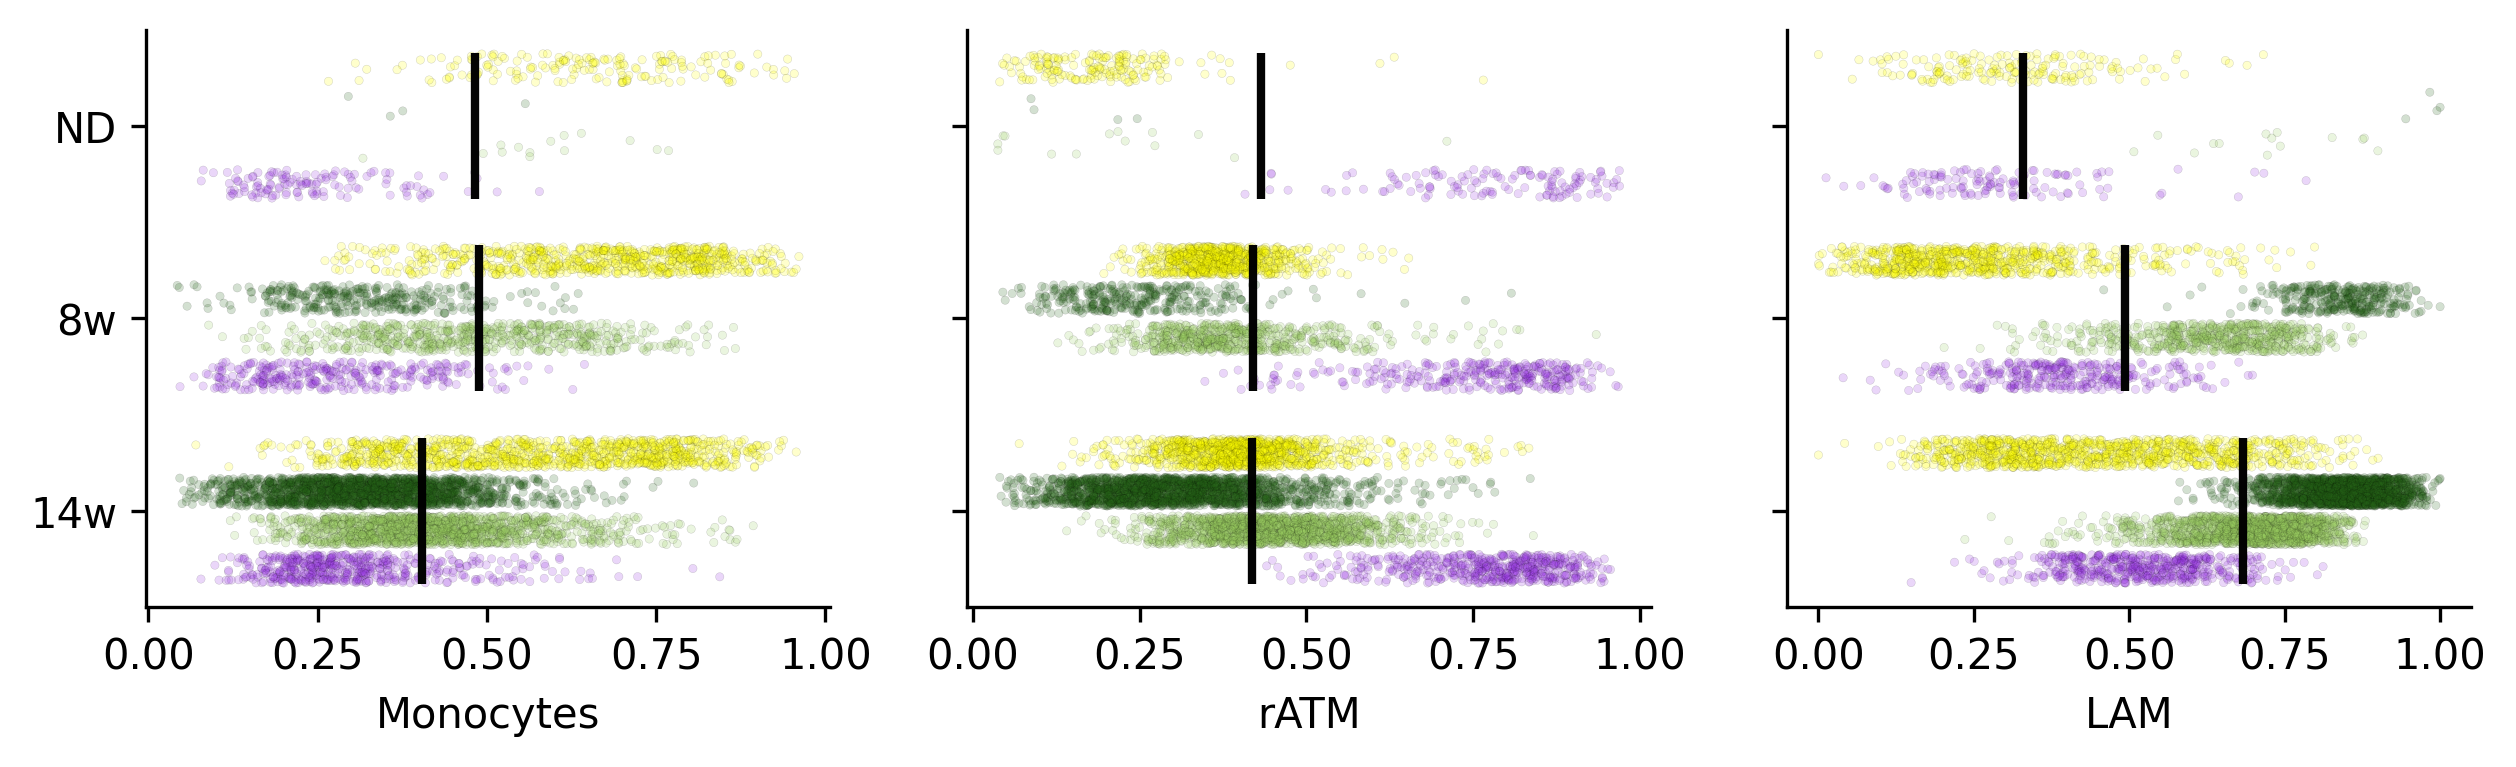

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 2.5


fig, axs =  plt.subplots(1, 3, sharey=True)

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}


poles = {
    'p1' : 'Monocytes',
    'p2' : 'rATM',
    'p3' : 'LAM',
}

pdf['keyName'] = pdf['key'].map(keyMap)

for i, (c, title) in enumerate(poles.items()):

    mu = pdf.groupby(['keyName'])[c].mean().reset_index()
    print(title)
    print(mu)
    print()
    

    sns.stripplot(data=mu, 
                  x=c,
                  y='keyName',
                  # hue='cellType',
                  s=35,
                  marker="|",
                  linewidth=2,
                  dodge=True,
                  edgecolor='k',
                  # palette=['#9835e4', '#9acd61', '#276419', 'yellow'],
                  legend=False,
                  alpha=0.99,
                  zorder=2,
                  ax=axs[i],
             )
    
    sns.stripplot(data=pdf, 
                  x=c,
                  y='keyName',
                  hue='cellType',
                  s=2,
                  jitter=0.3,
                  dodge=True,
                  edgecolor='k',
                  linewidth=0.1,
                  alpha=0.2,
                  zorder=1,
                  palette=['#9835e4', '#9acd61', '#276419', 'yellow'],
                  ax=axs[i])

    axs[i].invert_yaxis()
    axs[i].set_xlabel(title)
    axs[i].set_ylabel("")
    axs[i].legend().remove()


sns.despine()

In [10]:
mu

keyName        p3
0     14w  0.683209
1      8w  0.492787
2      ND  0.328897

In [ ]:
break

Monocytes
  keyName        p1
0     14w  0.408701
1      8w  0.524034
2      ND  0.564695

rATM
  keyName        p2
0     14w  0.421683
1      8w  0.438025
2      ND  0.366640

LAM
  keyName        p3
0     14w  0.678719
1      8w  0.424999
2      ND  0.320696



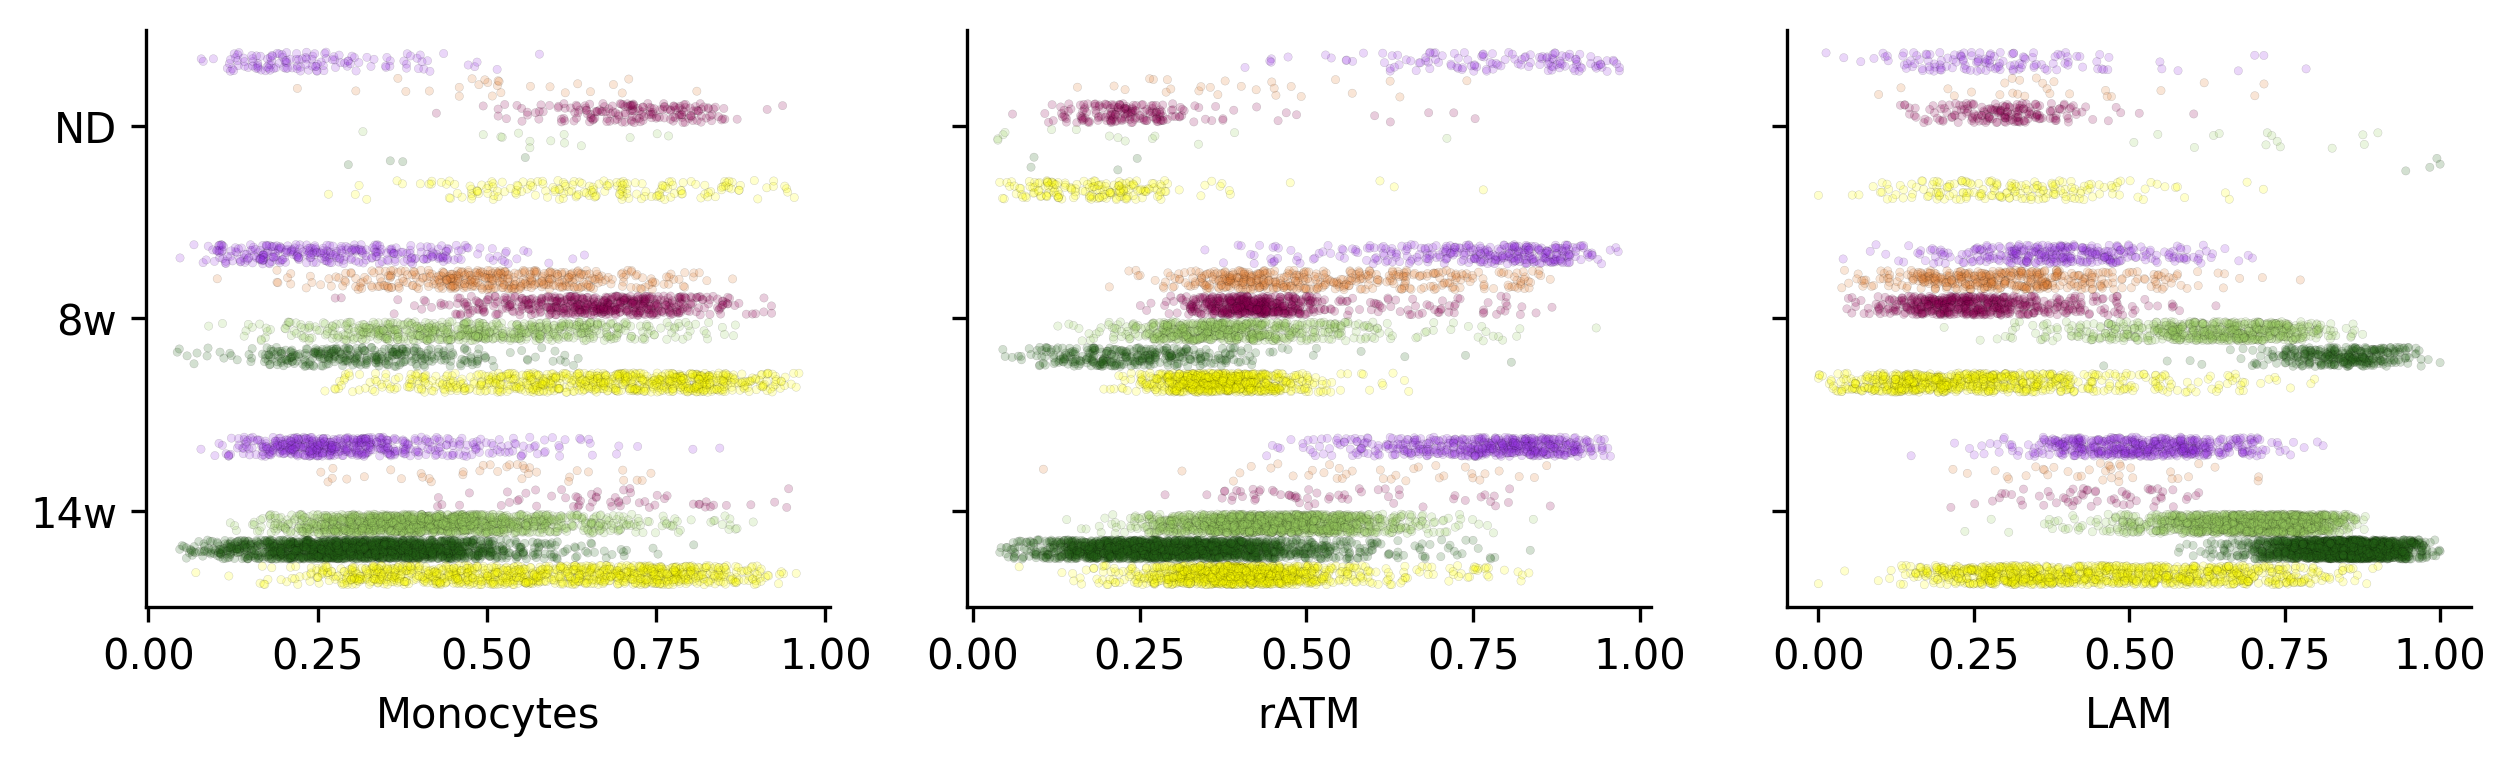

In [13]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# remove outliers before fitting models
lb = 0.001
ub = 0.999
pdf = cont.filterPoints(pdf, lb, ub)

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 10, 2.5


fig, axs =  plt.subplots(1, 3, sharey=True)

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}


poles = {
    'p1' : 'Monocytes',
    'p2' : 'rATM',
    'p3' : 'LAM',
}

pdf['keyName'] = pdf['key'].map(keyMap)

for i, (c, title) in enumerate(poles.items()):

    mu = pdf.groupby(['keyName'])[c].mean().reset_index()
    print(title)
    print(mu)
    print()
    

    # sns.stripplot(data=mu, 
    #               x=c,
    #               y='keyName',
    #               # hue='cellType',
    #               s=35,
    #               marker="|",
    #               linewidth=2,
    #               dodge=True,
    #               edgecolor='k',
    #               # palette=['#9835e4', '#9acd61', '#276419', 'yellow'],
    #               legend=False,
    #               alpha=0.99,
    #               zorder=2,
    #               ax=axs[i],
    #          )
    
    sns.stripplot(data=pdf, 
                  x=c,
                  y='keyName',
                  hue='cellType',
                  s=2,
                  jitter=0.3,
                  dodge=True,
                  edgecolor='k',
                  linewidth=0.1,
                  alpha=0.2,
                  zorder=1,
                  palette=colors,
                  # palette=['#9835e4', '#9acd61', '#276419', 'yellow'],
                  ax=axs[i])

    # axs[i].invert_yaxis()
    axs[i].set_xlabel(title)
    axs[i].set_ylabel("")
    axs[i].legend().remove()


sns.despine()


(0.0, 1.0, 0.0, 1.0)

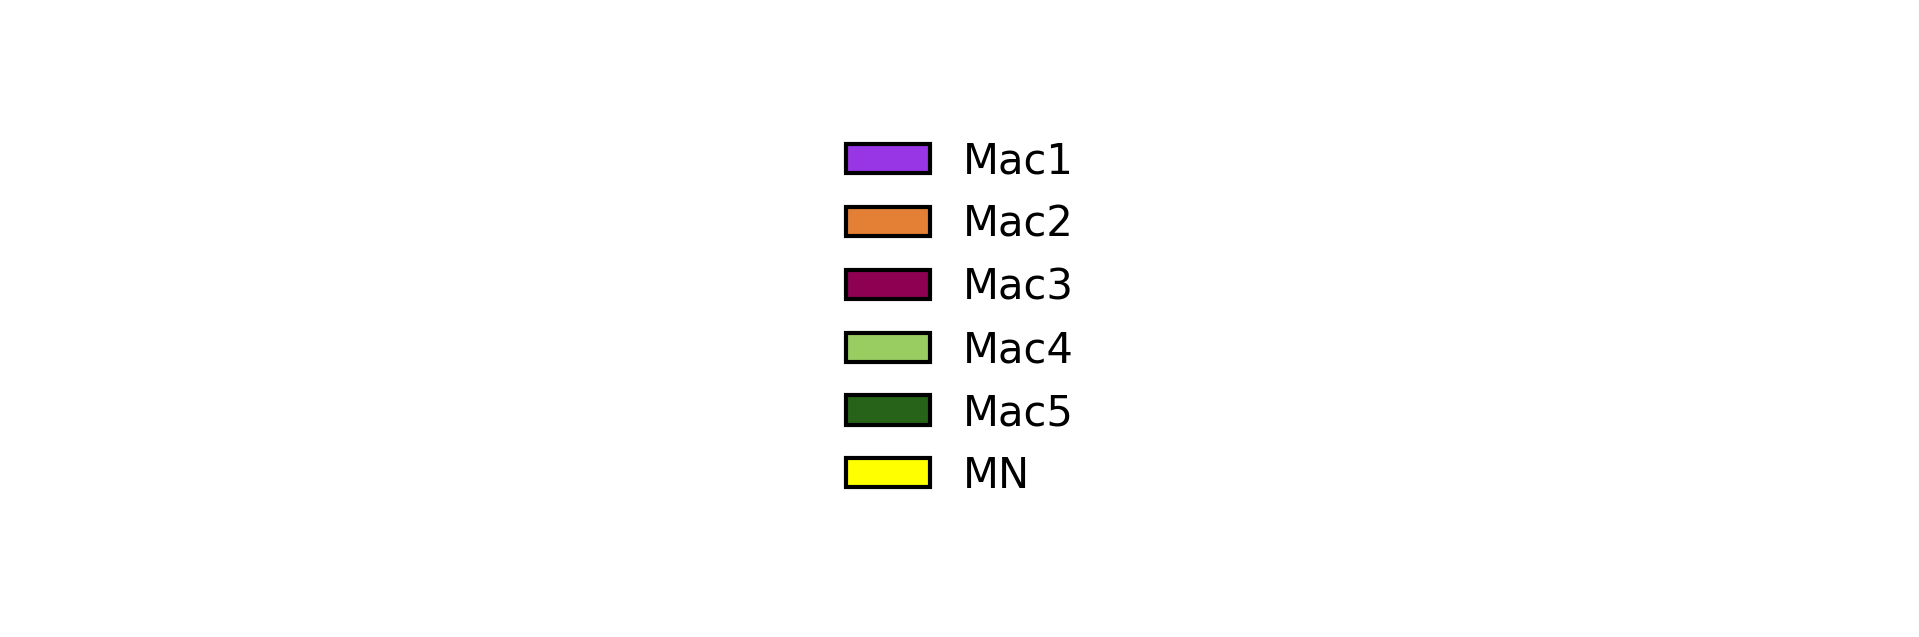

In [118]:
handles = []

labelColors = pdf[['cellType', 'color']].drop_duplicates()

for _, row in labelColors.iterrows():
    elem = Patch(color=row['color'], 
                 ec='k', 
                 label=row['cellType'])
    handles.append(elem)
    
plt.rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
ax.legend(handles=handles, 
          loc='center', 
          frameon=False,)
             
plt.gca().axis(False)

In [133]:
gx = pdf.groupby(['keyName', 'cellType']).agg(
    muMN = ('p1', 'mean'),
    stdMN = ('p1', 'std'),
    murATM = ('p2', 'mean'),
    stdrATM = ('p2', 'std'),
    muLAM = ('p3', 'mean'),
    stdLAM = ('p3', 'std'),
    
).reset_index()

gx = gx.sort_values(by='keyName', ascending=False)
gx = gx.style.format(decimal='.', precision=2)

print(gx..to_latex(index=False))


AttributeError: 'Styler' object has no attribute 'round'

  cellType  Correlation    color
0       MN     0.616754   yellow
1     Mac1     0.288486  #9835e4
2     Mac2     0.514747  #e48035
3     Mac3     0.676966  #8e0152
4     Mac4     0.442869  #9acd61
  cellType  Correlation    color
0       MN     0.377051   yellow
1     Mac1     0.764947  #9835e4
2     Mac2     0.516176  #e48035
3     Mac3     0.405825  #8e0152
4     Mac4     0.429586  #9acd61
  cellType  Correlation    color
0       MN     0.369972   yellow
1     Mac1     0.445545  #9835e4
2     Mac2     0.323555  #e48035
3     Mac3     0.282154  #8e0152
4     Mac4     0.674425  #9acd61


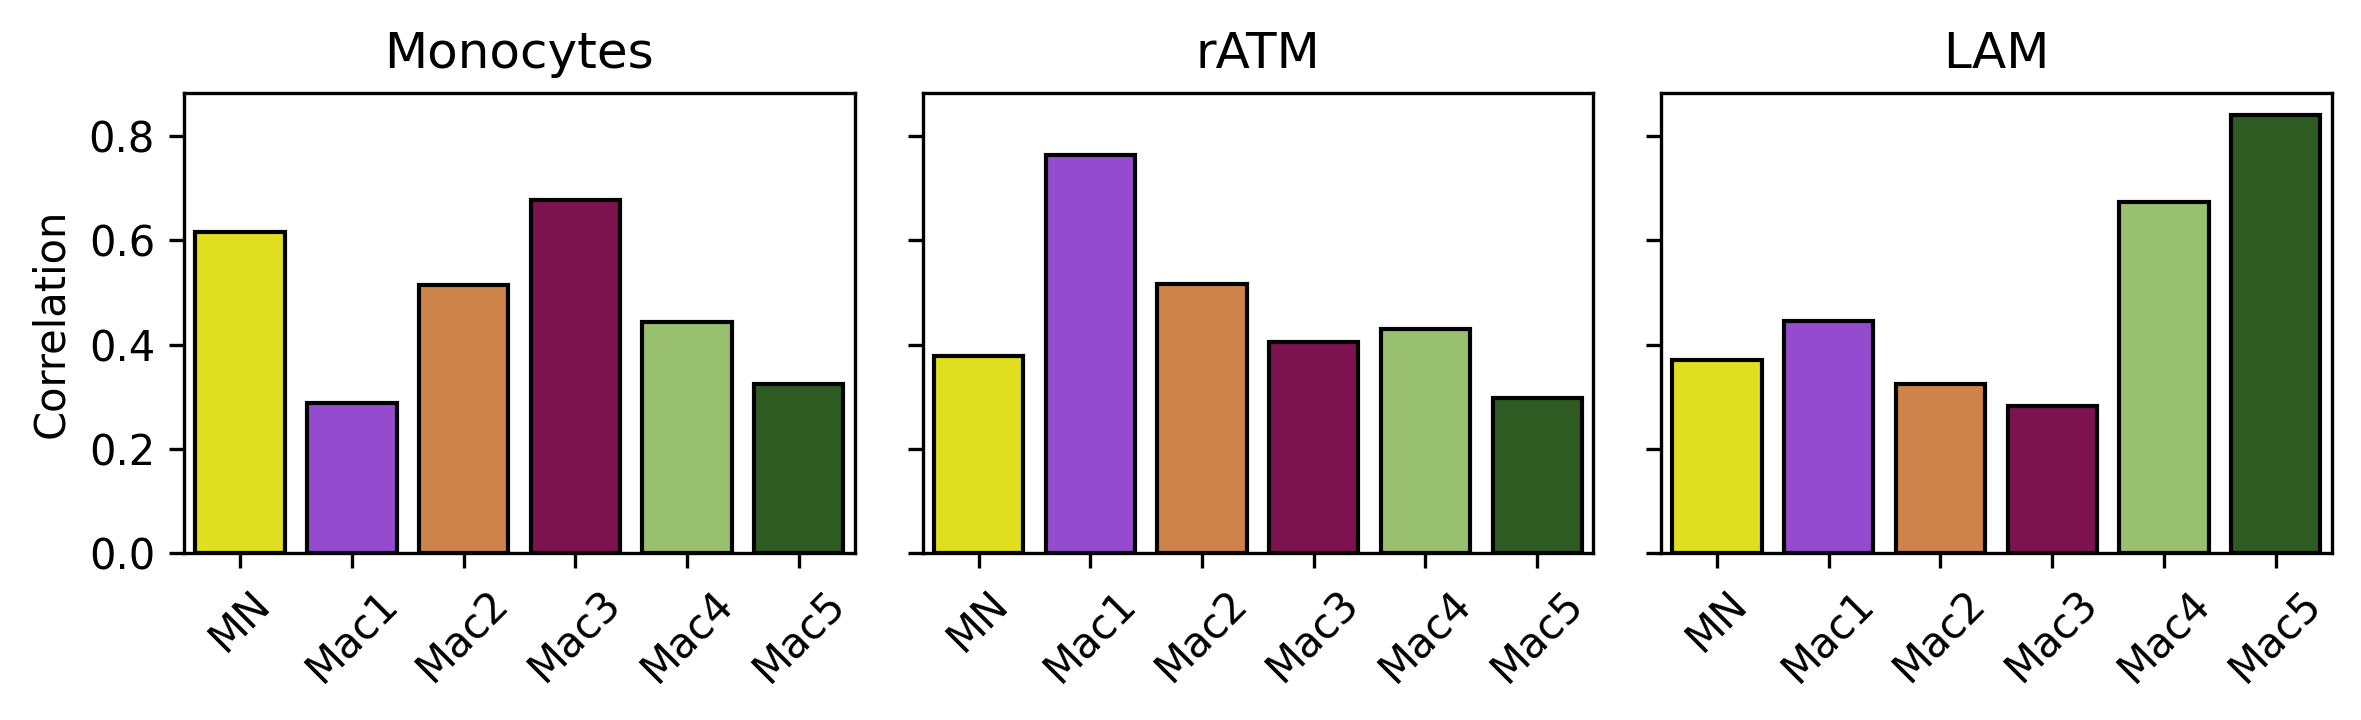

In [87]:
tmp = pdf.copy()

# tmp = tmp[tmp['key'] != "ND"]


plt.rcParams['figure.figsize'] = 8, 2.5
fig, axs = plt.subplots(1, 3, sharey=True)

for i, (c, title) in enumerate(poles.items()):

    gx = tmp.groupby(['cellType'])[c].mean().reset_index()
    gx.columns = ['cellType', 'Correlation']
    gx['color'] = gx['cellType'].map(colMap)
    # gx = gx.sort_values(by='cellType', ascending=False,)

    print(gx.head())


    sns.barplot(data=gx, 
                x='cellType',
                y='Correlation',
                # color=gx['color'].to_list(),
                # hue='cellType',
                ec='k',
                palette=['yellow'] + ut.MACCOLORS, 
                ax=axs[i],
                )

    if i == 0:
        axs[i].set_ylabel("Correlation")
    else:
        axs[i].set_ylabel("")

    axs[i].set_xlabel("")
    axs[i].set_title(title)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [99]:
tmp = pdf.copy()

decor = []

for i, cti in enumerate(tmp['cellType'].unique()):
    for j, ctj in enumerate(tmp['cellType'].unique()):
        for p in ['p1', 'p2', 'p3']:

            i_cor = tmp[tmp['cellType'] == cti][p].to_numpy()
            j_cor = tmp[tmp['cellType'] == ctj][p].to_numpy()

            score, pval = scipy.stats.ttest_ind(i_cor, j_cor)

            lfc = np.log2(np.mean(i_cor) + 1) - np.log2(np.mean(j_cor) + 1)

            row = {
                'cellType_i' : cti,
                'cellType_j' : ctj,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc, 
                'pole' : p,
            }

            decor.append(row)

decor = pd.DataFrame(decor)
decor.head()

cellType_i cellType_j      score           pval  log2foldchange pole
0       Mac1       Mac1   0.000000   1.000000e+00        0.000000   p1
1       Mac1       Mac1   0.000000   1.000000e+00        0.000000   p2
2       Mac1       Mac1   0.000000   1.000000e+00        0.000000   p3
3       Mac1       Mac2 -32.466888  2.819160e-173       -0.233400   p1
4       Mac1       Mac2  33.942238  3.036897e-185        0.219188   p2

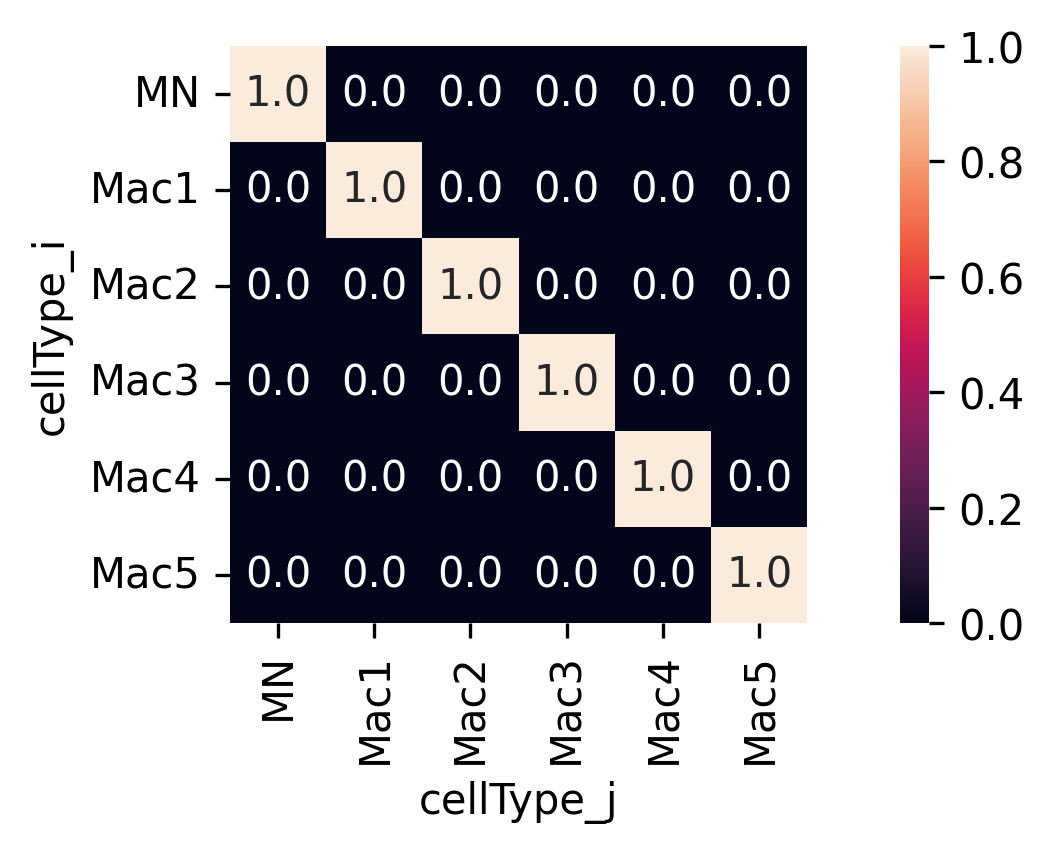

In [111]:
for pole in decor['pole'].unique():

    pdx = decor[decor['pole'] == pole]

    pdx = pd.pivot_table(pdx, 
                         index='cellType_i',
                         columns='cellType_j',
                         values='log2foldchange')

    sns.heatmap(data=pdx,
                square=True,
                annot=True,
                fmt=".1f")
    break

In [ ]:
break

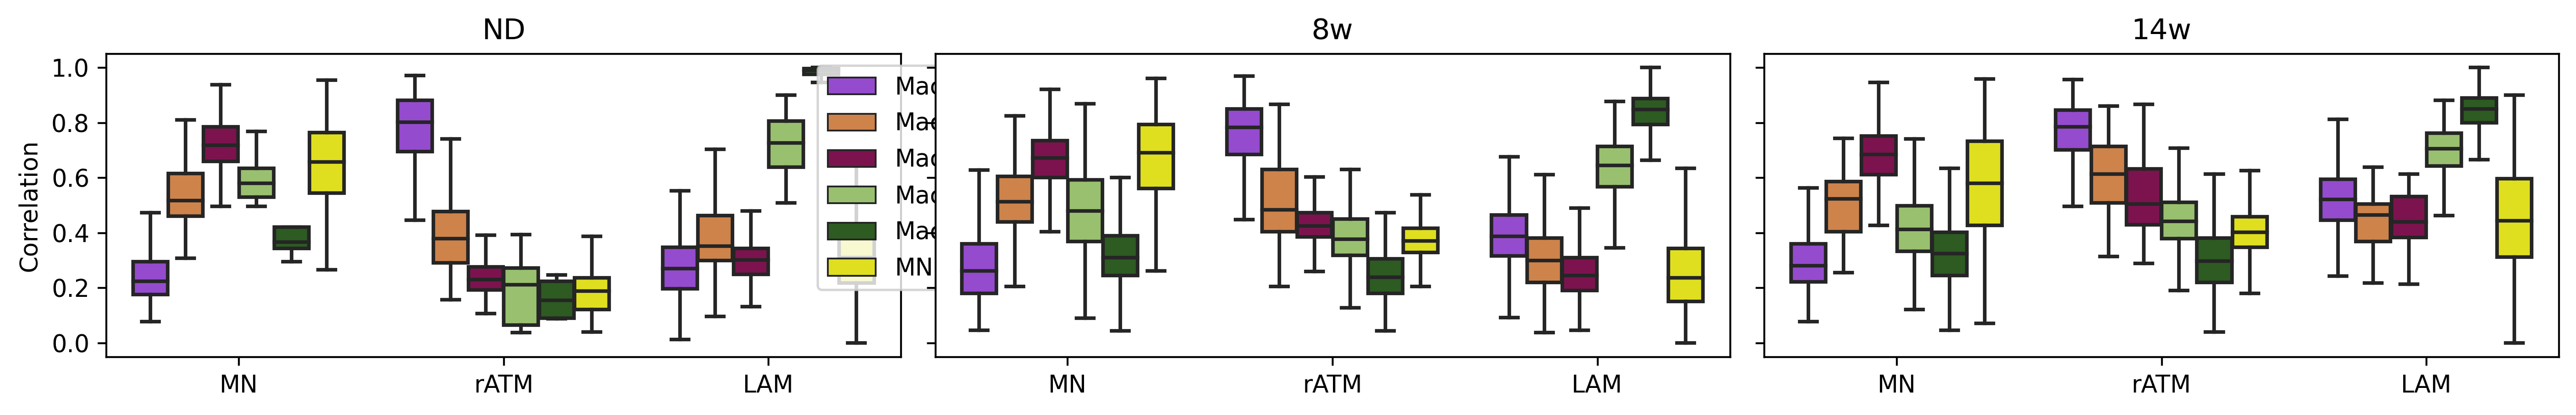

In [42]:


tmp = pdf.copy()

tmp = pd.melt(tmp, 
              id_vars=['cellId', 'keyName', 'cellType', 'color'],
              value_vars=['p1', 'p2', 'p3'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 15, 2.5

fig, axs = plt.subplots(1, 3, sharey=True)

varMap = {
    'p1' : 'MN',
    'p2' : 'rATM',
    'p3' : 'LAM',
}


for i, keyName in enumerate(tmp['keyName'].unique()):
    
    tmpx = tmp[tmp['keyName'] == keyName].reset_index()
    tmpx['variable'] = tmpx['variable'].map(varMap)
    sns.boxplot(data=tmpx, 
                x='variable',
                y='value',
                hue='cellType',
                palette=colors,
                showfliers=False,
                ax=axs[i])

    axs[i].set_title(keyName)

    if i == 0:
        axs[i].set_ylabel("Correlation")
    else:
        axs[i].set_ylabel("")
        axs[i].legend().remove()
    
    axs[i].set_xlabel("")


plt.tight_layout()
sns.move_legend(axs[0],
                loc='upper right',
                title="",
                bbox_to_anchor=(1.1, 1))

In [14]:
# outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG3/"
# fname = "3dPlot.csv"
# pdf.to_csv(f"{outdir}{fname}", index=False)

In [ ]:
break

In [ ]:
pdf = res.copy()
pdf = pdf[(pdf['p1'].notna()) & (pdf['p2'].notna())]
pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, False])

pdf['cellType'] = np.where(pdf['cellType'] == 'Monocytes', "MN", pdf['cellType'])

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 18, 6
plt.rcParams['figure.facecolor'] = "w"

fig = plt.figure()

for i, key in enumerate(keys):
    mask = (pdf['key'] == key)
    cx = pdf[mask]
    
    gx = cx.groupby(['cellType', 'color']).agg(
        n = ('p1', 'count'),
        xp1 = ('p1', 'mean'),
        rp1 = ('p1', 'std'),
        xp2 = ('p2', 'mean'),
        rp2 = ('p2', 'std'),
        xp3 = ('p3', 'mean'),
        rp3 = ('p3', 'std'),
        
    ).reset_index(drop=False)
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')  
    
    # ax.scatter(cx['p1'], 
    #        cx['p2'],
    #        cx['p3'], 
    #        c=cx['color'], 
    #        ec='k',
    #        s=50,
    #        alpha=1,
    #        zorder=1,
    #        lw=0.4,
    #        marker=".")
    
    
    for idx, row in gx.iterrows():
        if row['n'] > 40:
            
            sf = 2
            (xs,ys,zs) = drawSphere(row['xp1'], 
                                    row['xp2'], 
                                    row['xp3'], 
                                    row['rp1'] * sf,
                                    row['rp2'] * sf,
                                    row['rp3'] * sf)

            ax.plot_surface(xs, 
                            ys, 
                            zs,
                            rstride=1,
                            cstride=1,
                            alpha=0.4,
                            zorder=2,
                            color=row['color'],
                            shade=True,)
        
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    ax.set_title(keyMap[key])
    ax.set_xlabel(r"$r^2_{MN}$")
    ax.set_ylabel(r"$r^2_{ATM}$")
    ax.set_zlabel(r"$r^2_{LAM}$")

    ax.view_init(elev=50, azim=80)
    
# plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(3, 2)
axs = axs.ravel()


for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    cx = cx.sort_values(by='key', ascending=False,)
    print(ctype, cx.shape)
    
    # plot p1
    sns.kdeplot(data=cx,
                x='p1',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=axs[i])

    axs[i].set_title(ctype)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("MN", rotation=0, labelpad=10)
    axs[i].set_xlabel("")
    
    # set up second axis
    ax_divider = make_axes_locatable(axs[i])
    
    # plot p2
    ax2 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p2',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax2)
    
    ax2.sharex(axs[i])
    ax2.set_ylabel("ATM", rotation=0, labelpad=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel("")
    
    
    ax3 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p3',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax3)
    
    ax3.sharex(axs[i])
    ax3.set_ylabel("LAM", rotation=0, labelpad=10)
    ax3.set_yticks([])
    
    # format x axis
    ax3.set_xlabel("Correlation")
    # axs[i].set_xticks([0, 0.5, 1])
    axs[i].set_xlim([0, 1.1])

   
    
    # break
    
sns.despine()
plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 15
plt.rcParams['figure.facecolor'] = "w"

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 7
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

pdf = pdf[pdf['cellType'].isin(['Mac4', 'Mac5', 'Monocytes'])]


for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    cx = cx.sort_values(by='key', ascending=False,)
    print(ctype, cx.shape)
    
    # plot p1
    sns.kdeplot(data=cx,
                x='p1',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=axs[i])

    axs[i].set_title(ctype)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_ylabel("MN", rotation=0, labelpad=10)
    axs[i].set_xlabel("")
    
    # set up second axis
    ax_divider = make_axes_locatable(axs[i])
    
    # plot p2
    ax2 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p2',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax2)
    
    ax2.sharex(axs[i])
    ax2.set_ylabel("ATM", rotation=0, labelpad=10)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_xlabel("")
    
    
    ax3 = ax_divider.append_axes("bottom", 
                                 size="100%", 
                                 pad=f"25%")
    
    sns.kdeplot(data=cx,
                x='p3',
                hue='key',
                # common_norm=False,
                clip_on=True,
                shade=True,
                linewidth=1,
                legend=False,
                palette='viridis',
                ax=ax3)
    
    ax3.sharex(axs[i])
    ax3.set_ylabel("LAM", rotation=0, labelpad=10)
    ax3.set_yticks([])
    
    # format x axis
    ax3.set_xlabel("Correlation")
    # axs[i].set_xticks([0, 0.5, 1])
    axs[i].set_xlim([0, 1.1])

   
    
    # break
    
sns.despine()
plt.tight_layout()

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

pdf = pdf.sort_values(by=['cellType', 'key'], ascending=[True, True])
pdf = pdf.reset_index(drop=True)


metric = 'euclidean'
dist = metrics.pairwise_distances(pdf[['p1', 'p2', 'p3']], 
                                  metric=metric)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = "w"

cmap = plt.cm.get_cmap('plasma', lut=8)
# cmColors = ["lightgrey", "orangered"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cmColors)

plt.imshow(dist, cmap=cmap)

lines = pdf[pdf['cellType'].astype('category').cat.codes.diff() != 0].index.tolist()
for l in lines:
    plt.axvline(x=l, c='k', lw=1)
    plt.axhline(y=l, c='k', lw=1)
    
# set up ticks 
ticks = lines.copy()
ticks.append(len(pdf))
ticks = [np.sum(ticks[i:i+2])//2 for i in range(len(ticks)-1)]
tickLabels = pdf['cellType'].unique()

_ = plt.xticks(ticks, tickLabels, rotation=90)
_ = plt.yticks(ticks, tickLabels)

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# drop nan correlations
pdf = pdf[pdf['p1'].notna()]
pdf = pdf[pdf['p2'].notna()]
pdf = pdf[pdf['p3'].notna()]


# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

for pi, key in enumerate(keys):
    cx = pdf[pdf['key'] == key]
    cx = cx.sort_values(by='cellType', ascending=True)
    cx = cx.reset_index(drop=True)


    metric = 'euclidean'
    dist = metrics.pairwise_distances(cx[['p1', 'p2', 'p3']], 
                                      metric=metric)



    # get square ranges
    blocks = cx[cx['cellType'].astype('category').cat.codes.diff() != 0].index.tolist()
    blocks.append(len(cx))
    blocks = [blocks[i:i+2] for i in range(len(blocks)-1)]

    A = np.zeros((6, 6))

    for i, ib in enumerate(blocks):
        for j, jb in enumerate(blocks):

            win = dist[ib[0]:ib[1], jb[0]:jb[1]]
            # A[i, j] = np.median(win)
            A[i, j] = np.mean(win)
            # A[i, j] = np.std(win)

    A = pd.DataFrame(A)

    # get the upper triagle mask
    mask = np.zeros_like(A, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False


    A.index = cx['cellType'].unique()
    A.columns = cx['cellType'].unique()

    sns.heatmap(data=A,
                # linewidth=0.5,
                # linecolor='k',
                vmin=0, 
                vmax=1,
                annot=True, 
                mask=mask,
                square=True,
                cbar=False,
                # annot_kws={'rotation': 45},
                fmt=".2f",
                cmap='magma',
                ax=axs[pi]
                )

    axs[pi].tick_params(axis='y', rotation=0)
    axs[pi].set_title(keyMap[key])

sns.despine(top=True, 
            right=True, 
            left=True, 
            bottom=True)
    
plt.tight_layout()

In [ ]:
dist.shape

In [ ]:
pdf = res.copy()

# convert distances to correlations
pdf['p1'] = 1 - pdf['p1']
pdf['p2'] = 1 - pdf['p2']
pdf['p3'] = 1 - pdf['p3']

# rename time points
keyMap = {
    "ND" : "ND",
    "HFD8" : "8w",
    "HFD14" : "14w",
}
pdf['keyName'] = pdf['key'].map(keyMap)

mncolor = 'yellow'

colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
    mncolor,
]

colMap = dict(zip(macTypes, colors))
colMap['MN'] = mncolor
pdf['color'] = pdf['cellType'].map(colMap)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.5, 5
plt.rcParams['figure.facecolor'] = "w"
fig, axs = plt.subplots(3, 2)
axs = axs.ravel()

for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
    cx = pdf[pdf['cellType'] == ctype].reset_index()
    
    # # filter out cells with low counts
    # cx['nTime'] = cx.groupby('key')['cellId'].transform('count')
    # cx = cx[cx['nTime'] > 100]
    
    cx = pd.melt(cx, 
                 id_vars=['keyName'],
                 value_vars=['p1', 'p2', 'p3'])
    
    sns.stripplot(data=cx, 
                x='keyName',
                y='value',
                # showfliers=False,
                s=2,
                alpha=0.2,
                dodge=True,
                zorder=2,
                hue='variable',
                palette=['yellow', '#9835e4', '#276419'],
                ax=axs[i])
    
    axs[i].axhline(y=0.5, 
                   lw=0.75, 
                   c='k', 
                   zorder=1)
    axs[i].set_title(ctype)
    axs[i].set_ylabel("Correlation")
    axs[i].set_xlabel("")
    axs[i].legend().remove()
    axs[i].set_ylim([0, 1])
    
    print(i, ctype)
    print(cx.head())

    
    # break


sns.despine()
plt.tight_layout()

In [ ]:
# pdf = res.copy()

# # convert distances to correlations
# pdf['p1'] = 1 - pdf['p1']
# pdf['p2'] = 1 - pdf['p2']
# pdf['p3'] = 1 - pdf['p3']

# # rename time points
# keyMap = {
#     "ND" : "ND",
#     "HFD8" : "8w",
#     "HFD14" : "14w",
# }
# pdf['keyName'] = pdf['key'].map(keyMap)

# mncolor = 'yellow'

# colors = [
#     '#9835e4',
#     '#e48035',
#     '#8e0152',
#     '#9acd61',
#     '#276419',
#     mncolor,
# ]

# colMap = dict(zip(macTypes, colors))
# colMap['MN'] = mncolor
# pdf['color'] = pdf['cellType'].map(colMap)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6.5, 5
# plt.rcParams['figure.facecolor'] = "w"
# fig, axs = plt.subplots(3, 2)
# axs = axs.ravel()

# for i, ctype in enumerate(sorted(pdf['cellType'].unique())):
    
#     cx = pdf[pdf['cellType'] == ctype].reset_index()
    
#     # # filter out cells with low counts
#     # cx['nTime'] = cx.groupby('key')['cellId'].transform('count')
#     # cx = cx[cx['nTime'] > 100]
    
#     cx = pd.melt(cx, 
#                  id_vars=['keyName'],
#                  value_vars=['p1', 'p2', 'p3'])
    
#     sns.boxplot(data=cx, 
#                 x='keyName',
#                 y='value',
#                 showfliers=False,
#                 # s=2,
#                 # alpha=0.2,
#                 # dodge=True,
#                 # zorder=2,
#                 hue='variable',
#                 palette=['yellow', '#9835e4', '#276419'],
#                 ax=axs[i])
    
#     axs[i].axhline(y=0.5, 
#                    lw=0.75, 
#                    c='k', 
#                    zorder=1)
#     axs[i].set_title(ctype)
#     axs[i].set_ylabel("Correlation")
#     axs[i].set_xlabel("")
#     axs[i].legend().remove()
#     axs[i].set_ylim([0, 1])
    
#     print(i, ctype)
#     print(cx.head())

    
#     # break


# sns.despine()
# plt.tight_layout()

In [ ]:


# sns.jointplot(data=pdf, 
#               x="p2", 
#               y="p3", 
#               palette=colors,
#               hue="cellType")

# sns.jointplot(data=pdf, 
#               x='p1', 
#               y='p2',
#               kind="hex", 
#               color="#4CB391")

# sns.lmplot(
#     data=pdf,
#     x="p1", 
#     y="p2", 
#     hue="cellType",
#     palette=colors,
# )

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 18, 6
# plt.rcParams['figure.facecolor'] = "w"

# pdf = pdf.sort_values(by='cellType')

# g = sns.FacetGrid(pdf, 
#                   row="cellType", 
#                   hue="cellType", 
#                   height=1, 
#                   aspect=6,
#                   palette=colors,
#                   # palette='viridis',
#                  )

# # Draw the densities in a few steps
# g.map(sns.kdeplot, 
#       "p3", 
#       # bw_adjust=1, 
#       clip_on=True,
#       fill=True 
#      )


# # g.set_titles("")

# g.set(ylabel="", 
#       xlim=[0, 1],
#       xticks=[0, 1],
#       # xticklabels=['MN', 'LAM']
#      )

In [ ]:
# sys.path.append("/home/cstansbu/.local/lib/python3.7/site-packages/")
# import plotly.express as px
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import *
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# init_notebook_mode(connected=True) 


# fig = px.scatter_3d(pdf, 
#                     x='p1', 
#                     y='p2',
#                     z='p3',
#                     labels={
#                       "p1": "Monocyte Correlation",
#                       "p2": "ATM Correlation",
#                       "p3": "LAM Correlation",
#                     },
#                     color='cellType',
#                     color_discrete_sequence=colors,
#                     width=800, 
#                     height=800)

# fig.update_traces(marker=dict(size=5,
#                               line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# fig.write_html("test.html")
# print('done')

In [ ]:
# fig = make_subplots(rows=1, 
#                     cols=3,
#                     specs=[[{'is_3d': True}, 
#                            {'is_3d': True},
#                            {'is_3d': True},]]
#                    )


# for i, key in enumerate(keys):
#     mask = (pdf['key'] == key)
#     cx = pdf[mask]
    
#     fig.add_trace(go.Scatter3d(x=cx['p1'], 
#                                y=cx['p2'],  
#                                z=cx['p3'],
#                                mode='markers',
#                                marker=dict(
#                                    size=5,
#                                    color=cx['color'],
#                                    line_width=1)
#                               ),
#                 row=1, 
#                 col=i+1,
#             )

    
#     break
# fig.show()



In [ ]:
# dir(go.Scatter)